# Getting Started with Powerbox

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

There are two useful classes in ``powerbox``: the basic ``PowerBox``, and one for log-normal fields: ``LogNormalPowerBox``. You can import them like this:

In [1]:
from powerbox import PowerBox, LogNormalPowerBox

Once imported, to see all the options, just use ``help(PowerBox)``.

## Create a 2D Gaussian field with power-law power-spectrum

For a basic 2D Gaussian field with a power-law power-spectrum, one can use the following:

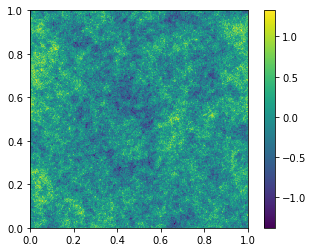

In [10]:
pb = PowerBox(N=512,                     # Number of grid-points in the box
              dim=2,                     # 2D box
              pk = lambda k: 0.1*k**-2., # The power-spectrum
              boxlength = 1.0,           # Size of the box (sets the units of k in pk)
              seed = 1010)               # Set a seed to ensure the box looks the same every time (optional)

plt.imshow(pb.delta_x,extent=(0,1,0,1))
plt.colorbar()
plt.show()

The ``delta_x`` output is *always* zero-mean, so it can be interpreted as an over-density field, $\rho(x)/\bar{\rho} -1$. The caveat to this is that an overdensity field is physically invalid below -1. To ensure the physical validity of the field, the option ``ensure_physical`` can be set, which clips the field: 

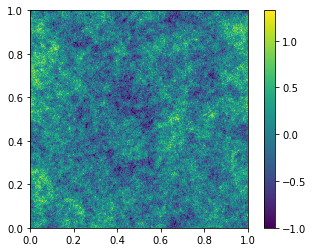

In [11]:
pb = PowerBox(N=512,                     # Number of grid-points in the box
              dim=2,                     # 2D box
              pk = lambda k: 0.1*k**-2., # The power-spectrum
              boxlength = 1.0,           # Size of the box (sets the units of k in pk)
              seed = 1010,               # Set a seed to ensure the box looks the same every time (optional)
              ensure_physical=True)      # ** Ensure the delta_x is a physically valid over-density **

plt.imshow(pb.delta_x,extent=(0,1,0,1))
plt.colorbar()
plt.show()

If you are actually dealing with over-densities, then this clipping solution is probably a bit hacky. What you want is a log-normal field...

## Create a 2D Log-Normal field with power-law power spectrum

The ``LogNormalPowerBox`` class is called in exactly the same way, but the resulting field has a log-normal pdf with the same power spectrum.

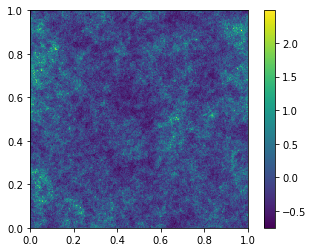

In [12]:
lnpb = LogNormalPowerBox(N=512,                     # Number of grid-points in the box
                         dim=2,                     # 2D box
                         pk = lambda k: 0.1*k**-2., # The power-spectrum
                         boxlength = 1.0,           # Size of the box (sets the units of k in pk)
                         seed = 1010)               # Use the same seed as our powerbox

plt.imshow(lnpb.delta_x,extent=(0,1,0,1))
plt.colorbar()
plt.show()

Again, the ``delta_x`` is zero-mean, but has a longer positive tail due to the log-normal nature of the distribution. This means it is always greater than -1, so that the over-density field is always physical.

## Create some discrete samples on the field

``powerbox`` lets you easily create samples that follow the field:

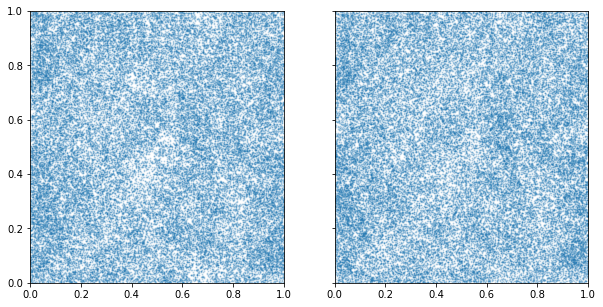

In [18]:
fig, ax = plt.subplots(1,2, sharex=True,sharey=True,gridspec_kw={"hspace":0}, subplot_kw={"ylim":(0,1),"xlim":(0,1)}, figsize=(10,5))

# Create a discrete sample using the PowerBox instance.
samples = pb.create_discrete_sample(nbar=50000,      # nbar specifies the number density
                                    min_at_zero=True  # by default the samples are centred at 0. This shifts them to be positive.
                                   ) 
ln_samples = lnpb.create_discrete_sample(nbar=50000, min_at_zero=True) 

# Plot the samples
ax[0].scatter(samples[:,0],samples[:,1], alpha=0.2,s=1)
ax[1].scatter(ln_samples[:,0],ln_samples[:,1],alpha=0.2,s=1)
plt.show()

Within each grid-cell, the placement of the samples is uniformly random. The samples can instead be placed on the cell edge by setting ``randomise_in_cell`` to ``False``.

## Check the power-spectrum of the field

``powerbox`` also contains a function for computing the (isotropic) power-spectrum of a field. This function accepts either a box defining the field values at every co-ordinate, *or* a set of discrete samples. In the latter case, the routine returns the power spectrum of over-densities, which matches the field that produced them. Let's go ahead and compute the power spectrum of our boxes, both from the samples and from the fields themselves:

In [19]:
from powerbox import get_power

In [24]:
# Only two arguments required when passing a field
p_k_field, bins_field = get_power(pb.delta_x, pb.boxlength)
p_k_lnfield, bins_lnfield = get_power(lnpb.delta_x, lnpb.boxlength)

# The number of grid points are also required when passing the samples
p_k_samples, bins_samples = get_power(samples, pb.boxlength,N=pb.N)
p_k_lnsamples, bins_lnsamples = get_power(ln_samples, lnpb.boxlength,N=lnpb.N)


Now we can plot them all together to ensure they line up:

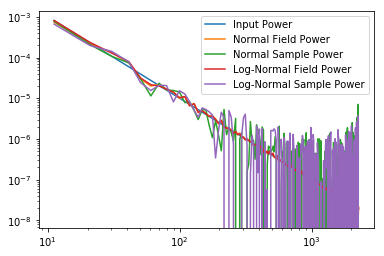

In [26]:
plt.plot(bins_field, 0.1*bins_field**-2., label="Input Power")

plt.plot(bins_field, p_k_field,label="Normal Field Power")
plt.plot(bins_samples, p_k_samples,label="Normal Sample Power")
plt.plot(bins_lnfield, p_k_lnfield,label="Log-Normal Field Power")
plt.plot(bins_lnsamples, p_k_lnsamples,label="Log-Normal Sample Power")

plt.legend()
plt.xscale('log')
plt.yscale('log')
